In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
pd.read_csv('/Users/danielnickas/Downloads/NFL_DATABOWL_2025/NFL_kicker_proj/nfl_kick_attempts(in).csv').head(10)

,season,week,game_id,game_date,posteam,defteam,kick_type,extra_point,made,kicker_player_id,kicker_player_name,kick_distance,qtr,quarter_seconds_remaining,score_differential
0,1999,1,1999_01_ARI_PHI,9/12/1999,PHI,ARI,XP,1,1,00-0008593,N.Johnson,20,1,473,6
1,1999,1,1999_01_ARI_PHI,9/12/1999,PHI,ARI,XP,1,1,00-0008593,N.Johnson,20,1,139,13
2,1999,1,1999_01_ARI_PHI,9/12/1999,PHI,ARI,XP,1,1,00-0008593,N.Johnson,20,1,16,20
3,1999,1,1999_01_ARI_PHI,9/12/1999,ARI,PHI,FG,0,1,00-0008080,C.Jacke,31,2,900,-21
4,1999,1,1999_01_ARI_PHI,9/12/1999,ARI,PHI,FG,0,1,00-0008080,C.Jacke,25,2,401,-18
5,1999,1,1999_01_ARI_PHI,9/12/1999,PHI,ARI,FG,0,1,00-0008593,N.Johnson,25,2,4,15
6,1999,1,1999_01_ARI_PHI,9/12/1999,ARI,PHI,FG,0,1,00-0008080,C.Jacke,32,4,900,-12
7,1999,1,1999_01_ARI_PHI,9/12/1999,ARI,PHI,XP,1,1,00-0008080,C.Jacke,20,4,243,-3
8,1999,1,1999_01_ARI_PHI,9/12/1999,ARI,PHI,FG,0,1,00-0008080,C.Jacke,31,4,4,-2
9,1999,1,1999_01_BUF_IND,9/12/1999,IND,BUF,XP,1,1,00-0016830,M.Vanderjagt,20,1,215,6


In [ ]:
# Create data1 with selected columns for week 1 only
cols = [
    'week', 'kick_type', 'extra_point', 'made',
    'kicker_player_id', 'kicker_player_name', 'kick_distance', 'score_differential'
]
data = pd.read_csv('/Users/danielnickas/Downloads/NFL_DATABOWL_2025/NFL_kicker_proj/nfl_kick_attempts(in).csv')
data1 = data[data['week'] == 1][cols]
data1

,week,kick_type,extra_point,made,kicker_player_id,kicker_player_name,kick_distance,score_differential
0,1,XP,1,1,00-0008593,N.Johnson,20,6
1,1,XP,1,1,00-0008593,N.Johnson,20,13
2,1,XP,1,1,00-0008593,N.Johnson,20,20
3,1,FG,0,1,00-0008080,C.Jacke,31,-21
4,1,FG,0,1,00-0008080,C.Jacke,25,-18
...,...,...,...,...,...,...,...,...
54108,1,FG,0,0,00-0038097,C.York,56,-9
54109,1,XP,1,1,00-0035358,C.McLaughlin,33,15
54110,1,XP,1,1,00-0038097,C.York,33,-10
54111,1,XP,1,1,00-0035358,C.McLaughlin,33,15


In [9]:
# Find the most accurate kicker by field goal percentage (fg %)
# Assuming 'kick_type' == 'FG' for field goals and 'made' is 1 for made kicks
fg_data = data1[data1['kick_type'] == 'FG']
fg_summary = fg_data.groupby(['kicker_player_id', 'kicker_player_name']).agg(
    attempts=('made', 'count'),
    made=('made', 'sum')
).reset_index()
fg_summary['fg_pct'] = fg_summary['made'] / fg_summary['attempts']
most_accurate = fg_summary.sort_values('fg_pct', ascending=False)
most_accurate

,kicker_player_id,kicker_player_name,attempts,made,fg_pct
145,00-0039750,J.Karty,2,2,1.0
29,00-0012742,D.Pelfrey,2,2,1.0
123,00-0034450,G.Joseph,5,5,1.0
32,00-0013699,W.Richey,4,4,1.0
121,00-0034173,E.Pineiro,4,4,1.0
...,...,...,...,...,...
122,00-0034202,K.Vedvik,1,0,0.0
42,00-0019440,K.Heppner,1,0,0.0
85,00-0027119,D.Buehler,1,0,0.0
52,00-0020379,O.Pochman,1,0,0.0


In [11]:
# Custom weighted score for best week 1 kickers
# Weights: FG% (0.5), avg kick distance (0.2), close game (0.2), games played (0.1)
# Lower score differential = closer game, so use inverse for scoring

# Filter for week 1 field goals only
group_cols = ['kicker_player_id', 'kicker_player_name']
week1_fg = data1[data1['kick_type'] == 'FG']

# Aggregate stats per kicker
agg = week1_fg.groupby(group_cols).agg(
    attempts=('made', 'count'),
    made=('made', 'sum'),
    fg_pct=('made', 'mean'),
    avg_distance=('kick_distance', 'mean'),
    avg_score_diff=('score_differential', 'mean'),
    games_played=('score_differential', 'count')  # proxy for games if gameid not present
).reset_index()

# Normalize metrics for scoring
agg['fg_pct_norm'] = agg['fg_pct']  # already 0-1
agg['distance_norm'] = (agg['avg_distance'] - agg['avg_distance'].min()) / (agg['avg_distance'].max() - agg['avg_distance'].min())
agg['score_diff_norm'] = 1 - (agg['avg_score_diff'] - agg['avg_score_diff'].min()) / (agg['avg_score_diff'].max() - agg['avg_score_diff'].min())
agg['games_norm'] = (agg['games_played'] - agg['games_played'].min()) / (agg['games_played'].max() - agg['games_played'].min())

# Weighted score
agg['custom_score'] = (
    0.5 * agg['fg_pct_norm'] +
    0.2 * agg['distance_norm'] +
    0.2 * agg['score_diff_norm'] +
    0.1 * agg['games_norm']
)

agg.sort_values('custom_score', ascending=False).head(10)

,kicker_player_id,kicker_player_name,attempts,made,fg_pct,avg_distance,avg_score_diff,games_played,fg_pct_norm,distance_norm,score_diff_norm,games_norm,custom_score
53,00-0020578,M.Bryant,36,35,0.972222,37.055556,1.055556,36,0.972222,0.359396,0.520531,0.972222,0.759319
139,00-0038402,A.Carlson,1,1,1.000000,52.000000,1.000000,1,1.000000,0.728395,0.521739,0.000000,0.750027
114,00-0033138,S.Ficken,1,1,1.000000,31.000000,-21.000000,1,1.000000,0.209877,1.000000,0.000000,0.741975
71,00-0023252,R.Gould,36,34,0.944444,36.472222,2.250000,36,0.944444,0.344993,0.494565,0.972222,0.737356
121,00-0034173,E.Pineiro,4,4,1.000000,39.500000,-8.000000,4,1.000000,0.419753,0.717391,0.083333,0.735762
39,00-0018949,T.Seder,4,4,1.000000,35.000000,-12.000000,4,1.000000,0.308642,0.804348,0.083333,0.730931
143,00-0039409,C.Little,1,1,1.000000,53.000000,7.000000,1,1.000000,0.753086,0.391304,0.000000,0.728878
19,00-0006800,J.Hanson,21,20,0.952381,36.523810,-3.809524,21,0.952381,0.346267,0.626294,0.555556,0.726258
77,00-0025565,N.Folk,30,28,0.933333,35.733333,0.300000,30,0.933333,0.326749,0.536957,0.805556,0.719963
4,00-0001343,C.Blanchard,1,1,1.000000,32.000000,-14.000000,1,1.000000,0.234568,0.847826,0.000000,0.716479


In [13]:
# PCA Analysis to determine best kicker via week 1 statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare data for PCA - use numerical features only
pca_features = ['fg_pct', 'avg_distance', 'avg_score_diff', 'attempts', 'made']
pca_data = agg[pca_features].fillna(0)  # Fill any NaN values

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Add PCA results to dataframe
agg['pca1'] = pca_result[:, 0]
agg['pca2'] = pca_result[:, 1]

# Calculate distance from origin in PCA space (best performers should be outliers)
agg['pca_distance'] = np.sqrt(agg['pca1']**2 + agg['pca2']**2)

# Show PCA explained variance
print("PCA Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Explained Variance:", sum(pca.explained_variance_ratio_))

# Top kickers by PCA distance
print("\nTop kickers by PCA analysis:")
agg.sort_values('pca_distance', ascending=False)[['kicker_player_name', 'fg_pct', 'avg_distance', 'pca_distance']].head(10)

PCA Explained Variance Ratio: [0.41713483 0.28677934]
Total Explained Variance: 0.7039141658476337

Top kickers by PCA analysis:


,kicker_player_name,fg_pct,avg_distance,pca_distance
52,O.Pochman,0.000000,63.000000,5.781351
73,D.Rayner,0.000000,53.000000,5.486148
42,K.Heppner,0.000000,52.000000,5.391286
53,M.Bryant,0.972222,37.055556,4.387840
71,R.Gould,0.944444,36.472222,4.297072
93,G.Zuerlein,0.805556,39.805556,3.803808
36,A.Vinatieri,0.756757,36.054054,3.683926
60,J.Chandler,1.000000,25.800000,3.551859
24,N.Johnson,1.000000,25.000000,3.373523
75,S.Gostkowski,0.787879,36.606061,3.312933


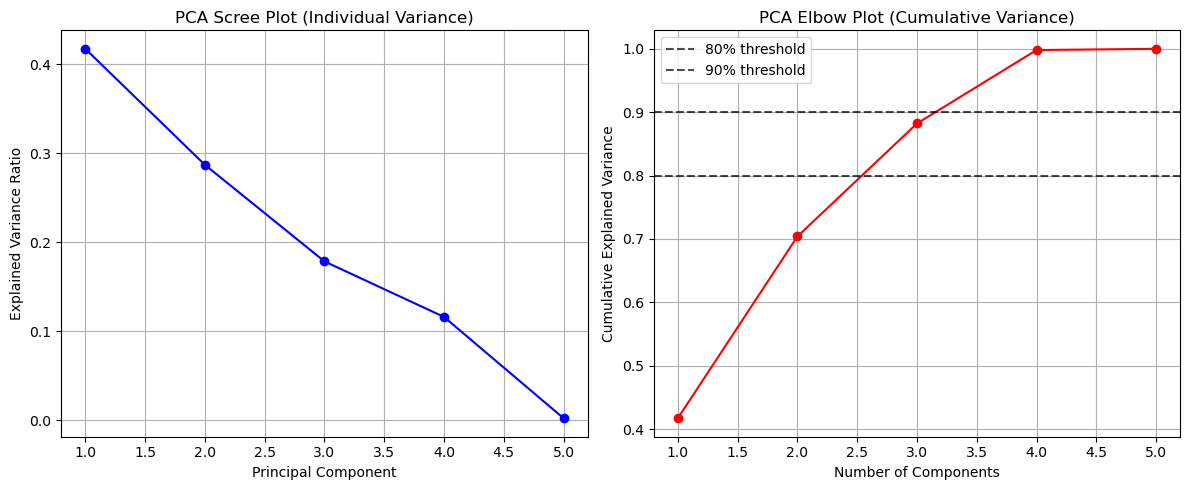

In [14]:
# PCA Elbow Plot to determine optimal number of components
pca_features = ['fg_pct', 'avg_distance', 'avg_score_diff', 'attempts', 'made']
pca_data = agg[pca_features].fillna(0)

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)

# Calculate explained variance for different numbers of components
n_components = min(len(pca_features), len(agg))  # Max components possible
explained_variance = []
cumulative_variance = []

for i in range(1, n_components + 1):
    pca_temp = PCA(n_components=i)
    pca_temp.fit(scaled_data)
    explained_variance.append(pca_temp.explained_variance_ratio_[-1])
    cumulative_variance.append(sum(pca_temp.explained_variance_ratio_))

# Create elbow plot
plt.figure(figsize=(12, 5))

# Individual explained variance
plt.subplot(1, 2, 1)
plt.plot(range(1, n_components + 1), explained_variance, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot (Individual Variance)')
plt.grid(True)

# Cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, n_components + 1), cumulative_variance, 'ro-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Elbow Plot (Cumulative Variance)')
plt.grid(True)
plt.axhline(y=0.8, color='k', linestyle='--', alpha=0.7, label='80% threshold')
plt.axhline(y=0.9, color='k', linestyle='--', alpha=0.7, label='90% threshold')
plt.legend()

plt.tight_layout()
plt.show()

PCA Component Loadings (Feature Importance):
                  PC1    PC2    PC3
fg_pct          0.289 -0.589 -0.067
avg_distance   -0.102  0.598  0.565
avg_score_diff  0.197 -0.424  0.817
attempts        0.650  0.266 -0.063
made            0.666  0.212 -0.065

Explained Variance by each component: [0.417 0.287 0.178]
Total explained variance with 3 components: 0.882


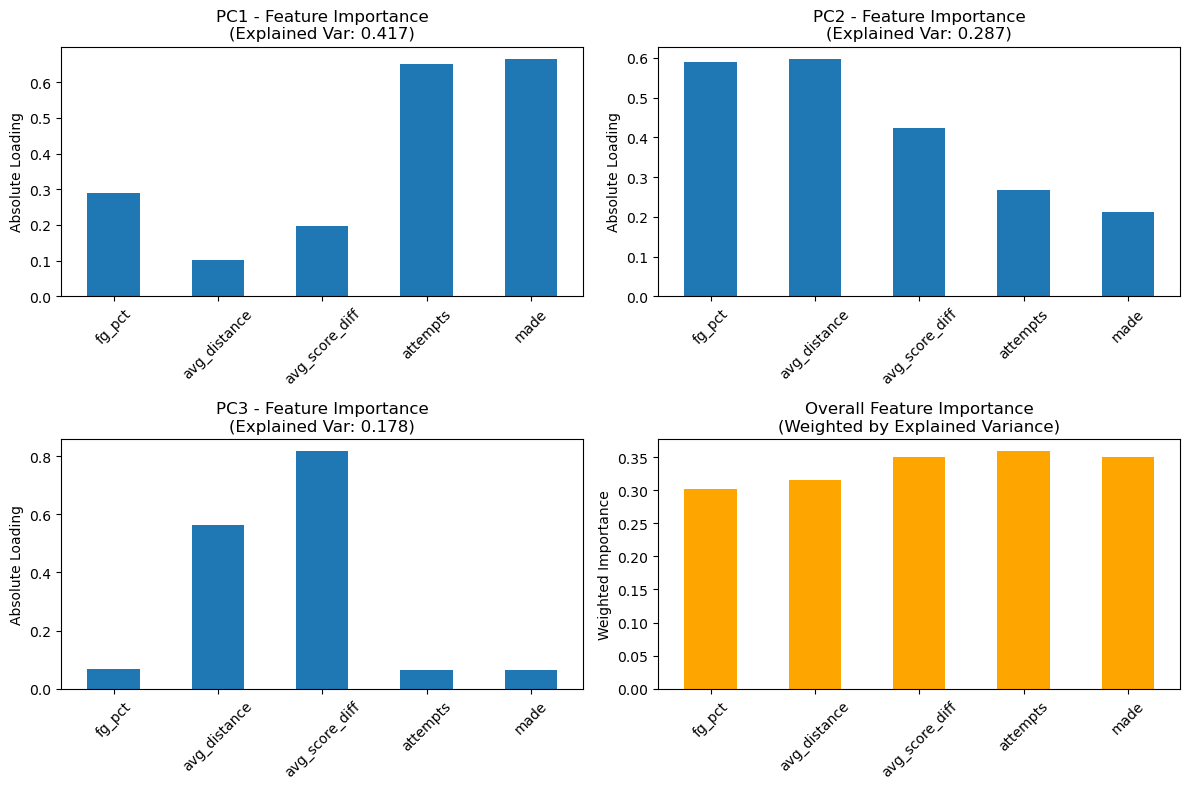


Most important features for determining best week 1 kicker:
1. attempts: 0.359
2. made: 0.350
3. avg_score_diff: 0.350
4. avg_distance: 0.315
5. fg_pct: 0.301


In [16]:
# Analyze feature importance in PCA components
pca_3comp = PCA(n_components=3)
pca_3comp.fit(scaled_data)

# Get the components (loadings) for each feature
components_df = pd.DataFrame(
    pca_3comp.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=pca_features
)

print("PCA Component Loadings (Feature Importance):")
print(components_df.round(3))
print(f"\nExplained Variance by each component: {pca_3comp.explained_variance_ratio_.round(3)}")
print(f"Total explained variance with 3 components: {sum(pca_3comp.explained_variance_ratio_):.3f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
for i, comp in enumerate(['PC1', 'PC2', 'PC3']):
    plt.subplot(2, 2, i+1)
    abs_loadings = abs(components_df[comp])
    abs_loadings.plot(kind='bar')
    plt.title(f'{comp} - Feature Importance\n(Explained Var: {pca_3comp.explained_variance_ratio_[i]:.3f})')
    plt.ylabel('Absolute Loading')
    plt.xticks(rotation=45)

# Overall feature importance (sum of absolute loadings weighted by explained variance)
plt.subplot(2, 2, 4)
weighted_importance = (abs(components_df) * pca_3comp.explained_variance_ratio_).sum(axis=1)
weighted_importance.plot(kind='bar', color='orange')
plt.title('Overall Feature Importance\n(Weighted by Explained Variance)')
plt.ylabel('Weighted Importance')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\nMost important features for determining best week 1 kicker:")
for i, (feature, importance) in enumerate(weighted_importance.sort_values(ascending=False).items()):
    print(f"{i+1}. {feature}: {importance:.3f}")

In [17]:
# Find the worst week 1 kickers based on multiple criteria
print("Worst Week 1 Kickers Analysis")
print("=" * 50)

# 1. Worst by field goal percentage (minimum 2 attempts to avoid small sample bias)
print("\n1. Worst by Field Goal Percentage (min 2 attempts):")
worst_fg_pct = agg[agg['attempts'] >= 2].sort_values('fg_pct').head(5)
print(worst_fg_pct[['kicker_player_name', 'attempts', 'made', 'fg_pct', 'avg_distance']].round(3))

# 2. Worst by average distance (shortest kicks, easier but missed)
print("\n2. Kickers who missed easiest kicks (shortest avg distance):")
missed_easy = agg[agg['fg_pct'] < 1.0].sort_values('avg_distance').head(5)
print(missed_easy[['kicker_player_name', 'attempts', 'made', 'fg_pct', 'avg_distance']].round(3))

# 3. Worst performance in high-pressure situations (close games)
print("\n3. Worst in close games (low score differential, poor performance):")
close_games = agg[abs(agg['avg_score_diff']) <= 7]  # Within one touchdown
worst_close = close_games.sort_values('fg_pct').head(5)
print(worst_close[['kicker_player_name', 'attempts', 'made', 'fg_pct', 'avg_score_diff']].round(3))

# 4. Overall worst performers using custom score (lowest scores)
print("\n4. Overall worst performers (lowest custom scores):")
worst_overall = agg.sort_values('custom_score').head(5)
print(worst_overall[['kicker_player_name', 'attempts', 'made', 'fg_pct', 'avg_distance', 'custom_score']].round(3))

# 5. Summary statistics for worst performers
print("\n5. Summary - Kickers with 0% field goal percentage:")
zero_pct = agg[agg['fg_pct'] == 0.0]
if len(zero_pct) > 0:
    print(f"Number of kickers with 0% FG: {len(zero_pct)}")
    print(zero_pct[['kicker_player_name', 'attempts', 'avg_distance', 'avg_score_diff']].round(3))
else:
    print("No kickers with 0% field goal percentage in week 1")

Worst Week 1 Kickers Analysis

1. Worst by Field Goal Percentage (min 2 attempts):
    kicker_player_name  attempts  made  fg_pct  avg_distance
127          A.Seibert         3     1   0.333        47.000
22            M.Husted         3     1   0.333        45.333
70            M.Koenen         4     2   0.500        39.250
34       P.Stoyanovich         2     1   0.500        32.500
31          T.Peterson         4     2   0.500        31.500

2. Kickers who missed easiest kicks (shortest avg distance):
    kicker_player_name  attempts  made  fg_pct  avg_distance
76           J.Medlock         3     2   0.667         26.00
59            A.Elling         2     1   0.500         27.50
11        R.Cunningham         2     1   0.500         28.00
108           A.Franks         3     2   0.667         30.00
144         B.Narveson         4     3   0.750         30.75

3. Worst in close games (low score differential, poor performance):
    kicker_player_name  attempts  made  fg_pct  avg_sc

In [18]:
# Using PCA to find the worst week 1 kickers
print("\n" + "="*60)
print("PCA Analysis: Worst Week 1 Kickers")
print("="*60)

# For worst performers, we want to look at kickers who are outliers in the negative direction
# We'll use the existing PCA results but focus on different metrics

# Method 1: Lowest PCA distance (closest to average, indicating mediocre performance)
print("\n1. Most average/mediocre kickers (lowest PCA distance from origin):")
worst_pca_distance = agg.sort_values('pca_distance').head(5)
print(worst_pca_distance[['kicker_player_name', 'fg_pct', 'avg_distance', 'pca_distance']].round(3))

# Method 2: Kickers in negative PCA space (below average in key components)
print("\n2. Kickers with negative PCA1 scores (below average in primary component):")
negative_pca1 = agg[agg['pca1'] < 0].sort_values('pca1').head(5)
print(negative_pca1[['kicker_player_name', 'fg_pct', 'avg_distance', 'pca1', 'pca2']].round(3))

# Method 3: Create a "worst performer" score using inverted PCA logic
# Worst performers should have: low FG%, low distance, poor in pressure situations
worst_features = ['fg_pct', 'avg_distance', 'avg_score_diff', 'attempts', 'made']
worst_data = agg[worst_features].fillna(0)

# Invert fg_pct and avg_distance for "worst" analysis (lower is worse)
worst_data_inverted = worst_data.copy()
worst_data_inverted['fg_pct'] = 1 - worst_data_inverted['fg_pct']  # Invert FG%
worst_data_inverted['avg_distance'] = worst_data_inverted['avg_distance'].max() - worst_data_inverted['avg_distance']  # Invert distance

# Standardize and apply PCA to find worst performers
scaler_worst = StandardScaler()
scaled_worst = scaler_worst.fit_transform(worst_data_inverted)

pca_worst = PCA(n_components=2)
pca_worst_result = pca_worst.fit_transform(scaled_worst)

# Add worst PCA results
agg['pca_worst1'] = pca_worst_result[:, 0]
agg['pca_worst2'] = pca_worst_result[:, 1]
agg['pca_worst_distance'] = np.sqrt(agg['pca_worst1']**2 + agg['pca_worst2']**2)

print("\n3. Worst performers using inverted PCA analysis:")
print("(Higher distance = worse performance)")
worst_pca_performers = agg.sort_values('pca_worst_distance', ascending=False).head(5)
print(worst_pca_performers[['kicker_player_name', 'fg_pct', 'avg_distance', 'pca_worst_distance']].round(3))

# Method 4: Quadrant analysis - find kickers in the "worst" quadrant
print("\n4. Kickers in worst performance quadrant (low PCA1, low PCA2):")
worst_quadrant = agg[(agg['pca1'] < agg['pca1'].median()) & (agg['pca2'] < agg['pca2'].median())]
if len(worst_quadrant) > 0:
    worst_quadrant_sorted = worst_quadrant.sort_values(['pca1', 'pca2']).head(5)
    print(worst_quadrant_sorted[['kicker_player_name', 'fg_pct', 'avg_distance', 'pca1', 'pca2']].round(3))
else:
    print("No kickers found in the worst performance quadrant")

print(f"\nPCA Explained Variance for worst performers: {pca_worst.explained_variance_ratio_.round(3)}")


PCA Analysis: Worst Week 1 Kickers

1. Most average/mediocre kickers (lowest PCA distance from origin):
    kicker_player_name  fg_pct  avg_distance  pca_distance
81         D.Carpenter   0.818        38.636         0.136
120          D.Carlson   0.909        38.455         0.184
8           S.Christie   0.889        37.778         0.186
35        M.Vanderjagt   0.750        35.500         0.187
109            J.Lambo   0.833        38.083         0.247

2. Kickers with negative PCA1 scores (below average in primary component):
    kicker_player_name  fg_pct  avg_distance   pca1   pca2
73            D.Rayner     0.0          53.0 -3.283  4.395
42           K.Heppner     0.0          52.0 -3.265  4.290
52           O.Pochman     0.0          63.0 -3.175  4.831
85           D.Buehler     0.0          34.0 -2.529  1.503
122           K.Vedvik     0.0          45.0 -2.439  2.044

3. Worst performers using inverted PCA analysis:
(Higher distance = worse performance)
   kicker_player_name  

##### look at 4. in Kickers in worst performance quadrant 